# Baseline model for progression prediction

## Set-up

### Import librairies

In [5]:
import os, sys

from tqdm.notebook import tqdm
from typing import List, Dict

import pandas as pd
import numpy as np
import networkx as nx

import plotly.express as px
import plotly.io as pio

pio.templates.default = 'seaborn'

In [6]:
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))

### Fetch data

In [7]:
from utils import fetch_data

labels, lesions, patients = fetch_data(verbose=1)

Post-1 study lesions extracted for 88 patients
Post-1 study labels added for 88 patients
The intersection of datasets showed 88 potential datapoints.


### Prepare data

In [8]:
lesions_agg = lesions.groupby('gpcr_id').agg({
    'voxels': np.sum,
    'max_suv_val': np.mean,
    'mean_suv_val': np.mean,
    'min_suv_val': np.mean,
    'sd_suv_val': np.mean,
    'assigned_organ': pd.Series.tolist
}).reset_index()

dataset = lesions_agg.merge(patients, on='gpcr_id', how='inner')
dataset.set_index('gpcr_id', inplace=True)

In [9]:
from utils import Preprocessor

# Separate features by type
numerical = list(dataset.select_dtypes(np.number).columns)
categorical = list(dataset.select_dtypes([bool, object]).columns)
multivalue = ['assigned_organ', 'immuno_therapy_type']

# Remove multivalue features from categorical ones
for feature in multivalue:
    categorical.remove(feature)
    
features_range = list(range(len(numerical) + len(categorical) + len(multivalue)))
bp = np.cumsum([len(numerical), len(categorical), len(multivalue)])

# Build PipeLine of ColumnTransformers
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

ct = Pipeline([
    ('imputers', ColumnTransformer([
        ('median', SimpleImputer(strategy='median'), numerical),
        ('frequent', SimpleImputer(strategy='most_frequent'), categorical)
    ], remainder='passthrough')),
    ('preprocess', ColumnTransformer([
        ('scaler', StandardScaler(), features_range[0:bp[0]]),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), features_range[bp[0]:bp[1]]),
        ('count-vec1', CountVectorizer(analyzer=set), features_range[bp[1]:bp[2]][0]),
        ('count-vec2', CountVectorizer(analyzer=set), features_range[bp[1]:bp[2]][1])
    ], remainder='passthrough')),
])

ppor = Preprocessor(
    pipe=ct,
    feats_out_fn=lambda ct: ct.named_steps['imputers'].transformers_[0][2] \
        + list(ct.named_steps['preprocess'].transformers_[1][1].get_feature_names()) \
        + ct.named_steps['preprocess'].transformers_[2][1].get_feature_names() \
        + ct.named_steps['preprocess'].transformers_[3][1].get_feature_names())


In [10]:
from sklearn.model_selection import train_test_split

I_train, I_test, y_train, y_test = \
    train_test_split(labels.index, labels, test_size=0.2, random_state=27)
    
ppor.fit(dataset.loc[I_train])

X_train = ppor.transform(dataset.loc[I_train]) 
X_test = ppor.transform(dataset.loc[I_test]) 

y_train = labels.loc[I_train]
y_test = labels.loc[I_test]

## Testing different classifiers

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=7),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=.01, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(penalty='l2', solver='liblinear')]

In [21]:
scores = []

for name, clf in tqdm(zip(names, classifiers), total=len(names)):
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print(f'{name:<20} {accuracy_score(y_test, y_pred):,.4f}')
    
    scores.append((name, clf.score(X_test, y_test)))


  0%|          | 0/10 [00:00<?, ?it/s]

Nearest Neighbors    0.5000
Linear SVM           0.5556
RBF SVM              0.5556
Gaussian Process     0.4444
Decision Tree        0.7222
Random Forest        0.3333
Neural Net           0.7222
AdaBoost             0.5556
Naive Bayes          0.3889
Logistic Regression  0.8333


In [22]:
for method, score in list(scores):
    print(f'{method:<20} {score:,.4f}')

Nearest Neighbors    0.5000
Linear SVM           0.5556
RBF SVM              0.5556
Gaussian Process     0.4444
Decision Tree        0.7222
Random Forest        0.3333
Neural Net           0.7222
AdaBoost             0.5556
Naive Bayes          0.3889
Logistic Regression  0.8333


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, fig, ax):
    
    storage = []
    
    # Add testing accuracy
    storage.append(
        dict(metric='Accuracy', value=accuracy_score(y_true, y_pred))
    )
    
    # Add ROC AUC score
    # storage.append(
    #     dict(metric='ROC AUC', value=roc_auc_score(y_true, y_pred))
    # )
    
    # Add other binary classification metrics
    bin_class_metrics = precision_recall_fscore_support(y_true, y_pred, average='binary')
    for value, metric in zip(list(bin_class_metrics)[:-2], ['precision', 'recall']):
        storage.append(dict(metric=(metric.capitalize() + ' - testing'), value=value))

    mf = pd.DataFrame(confusion_matrix(y_true, y_pred))

    mf.columns, mf.index = ['NPD', 'PD'], ['NPD', 'PD']

    sns.heatmap(mf, annot=True, cmap='Blues', cbar=False, fmt='g', ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Ground Truth')
    
    return [f"{entry['metric'].split(' ')[0]}: {entry['value']:,.3f}" for entry in storage]

In [ ]:
[key for key in mpl.rcParams.keys() if 'font' in key ]

['font.cursive',
 'font.family',
 'font.fantasy',
 'font.monospace',
 'font.sans-serif',
 'font.serif',
 'font.size',
 'font.stretch',
 'font.style',
 'font.variant',
 'font.weight',
 'legend.fontsize',
 'legend.title_fontsize',
 'mathtext.fontset',
 'pdf.fonttype',
 'pdf.use14corefonts',
 'pgf.rcfonts',
 'ps.fonttype',
 'svg.fonttype']

Text(0.7, 0.95, 'Accuracy: 0.722 | Precision: 0.667 | Recall: 0.750')

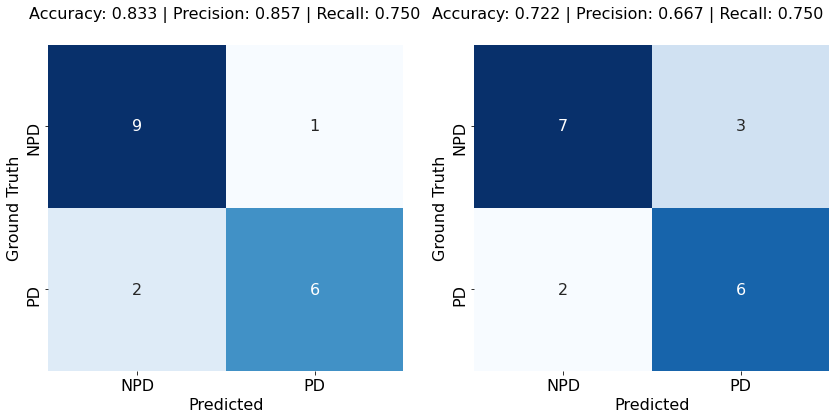

In [23]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

y_pred = dict(zip(names, classifiers))['Logistic Regression'].predict(X_test)

clean = plot_cm(y_test, y_pred, fig, ax[0])
fig.text(.3, .95, ' | '.join(clean), ha='center', va='center')

y_pred = dict(zip(names, classifiers))['Decision Tree'].predict(X_test)

clean = plot_cm(y_test, y_pred, fig, ax[1])
fig.text(.7, .95, ' | '.join(clean), ha='center', va='center')

In [42]:
def get_best_worst_coefs(classifier):
    for feature, coef in list(sorted(zip(ppor.get_feature_names(), classifier.coef_.reshape(-1)), key=lambda x: x[1], reverse=True))[:5]:
        print(f'{feature:<35} {coef:,.4f}')
        
    for feature, coef in list(sorted(zip(ppor.get_feature_names(), classifier.coef_.reshape(-1)), key=lambda x: x[1], reverse=False))[:5]:
        print(f'{feature:<35} {coef:,.4f}')

In [31]:
categorical

['sex',
 'NRAS_MUTATION',
 'BRAF_MUTATION',
 'concomittant_tvec',
 'concomittant_LAG3',
 'prior_targeted_therapy',
 'prior_treatment',
 'nivo_maintenance']

In [43]:
lsvm = dict(zip(names, classifiers))['Linear SVM']

get_best_worst_coefs(lsvm)

lympho_absolus_gl                   0.2113
lymphnode_lowerlimb                 0.1500
ldh_sang_ul                         0.1235
bmi                                 0.1161
x7_True                             0.1149
sd_suv_val                          -0.1794
x7_False                            -0.1149
bones_thorax                        -0.1049
liver                               -0.1001
lymphnode_abdomen                   -0.1000


In [47]:
logreg = dict(zip(names, classifiers))['Logistic Regression']

get_best_worst_coefs(logreg)

lymphnode_lowerlimb                 0.9021
min_suv_val                         0.7391
lympho_absolus_gl                   0.5376
ipi                                 0.4876
spleen                              0.4683
sd_suv_val                          -1.2611
liver                               -0.8778
vol_ccm                             -0.7178
x0_female                           -0.5521
pembro                              -0.4450


In [56]:
dtc = dict(zip(names, classifiers))['Decision Tree']

for feature, coef in list(sorted(zip(ppor.get_feature_names(), dtc.feature_importances_.reshape(-1)), key=lambda x: x[1], reverse=True))[:10]:
    print(f'{feature:<35} {coef:,.4f}')


bmi                                 0.2467
sd_suv_val                          0.2085
eosini_absolus_gl                   0.1549
age_at_treatment_start_in_years     0.0927
vol_ccm                             0.0864
x0_male                             0.0833
lymphnode_thorax                    0.0583
lympho_absolus_gl                   0.0437
x7_True                             0.0255
max_suv_val                         0.0000
